In [1]:
import pickle as pkl
import numpy as np

from src.models.train_emos import train_emos, train_and_test_emos
from src.visualization.pit import make_cpit_diagram_emos, make_cpit_hist_emos 
from src.visualization.brier_score import brier_skill_plot, brier_plot
from src.models.get_data import get_tensors, get_normalized_tensor
from src.models.emos import EMOS
from src.visualization.scoring_tables import make_table
from src.visualization.twcrpss_plot import make_twcrpss_plot
from src.models.emos import EMOS
from src.visualization.reliability_diagram import make_reliability_diagram
from src.training.training import load_model
from src.visualization.plot_forecasts import plot_forecast_cdf, plot_forecast_pdf

2024-03-13 11:37:19.148692: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 11:37:19.176097: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 11:37:19.176147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 11:37:19.176807: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-13 11:37:19.180949: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 11:37:19.181555: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
folder = '/net/pc200239/nobackup/users/hakvoort/models/emos/'

base_model = load_model(folder + 'trunc_normal/tn_crps_.pkl')
print(base_model)

Using given parameters for Truncated Normal distribution
EMOS Model Information:
Loss function: loss_CRPS_sample (Samples: 200)
Forecast distribution: distr_trunc_normal
Parameters:
  a_tn: [0.3965224]
  b_tn: [ 0.9656694  -0.01666058 -0.146118    0.03517735  0.00451683]
  c_tn: [1.5007248]
  d_tn: [1.0637333]
Features: wind_speed, press, kinetic, humid, geopot
Number of features: 5
Neighbourhood size: 11

Optimizer: Adam
Learning rate: 0.009999999776482582



In [3]:
test_fold = 3
ignore = ['229', '285', '323']
X_test, y_test, variances_test = get_tensors(base_model.neighbourhood_size, base_model.feature_names, test_fold, ignore)
X_test = (X_test - base_model.feature_mean) / base_model.feature_std

print(X_test.shape)

(7780, 5)


In [4]:
gev_folder = folder + 'gev/'

gev = load_model(gev_folder + 'gev_crps_.pkl')

gev_100 = load_model(gev_folder + 'gev_crps__epochs100.pkl')

t15 = load_model(gev_folder + 'gev_twcrps_threshold15.0.pkl')
t12 = load_model(gev_folder + 'gev_twcrps_threshold12.0.pkl')

mean12_std4 = load_model(gev_folder + 'gev_twcrps_mean12.0_std4.0.pkl')
mean12_std1 = load_model(gev_folder + 'gev_twcrps_mean12.0_std1.0.pkl')
mean16_std5 = load_model(gev_folder + 'gev_twcrps_mean16.0_std5.0.pkl')


gev_models = {'gev': gev, 'gev_100': gev_100}
t_models = {'t15': t15, 't12': t12}
cdf_models = {'mean12_std4': mean12_std4, 'mean12_std1': mean12_std1, 'mean16_std5': mean16_std5}

gev_models.pop('gev_100')

all_models = {**gev_models, **t_models, **cdf_models}

Using given parameters for Generalized Extreme Value distribution
Using given parameters for Generalized Extreme Value distribution
Using given parameters for Generalized Extreme Value distribution
Using given parameters for Generalized Extreme Value distribution
Using given parameters for Generalized Extreme Value distribution
Using given parameters for Generalized Extreme Value distribution
Using given parameters for Generalized Extreme Value distribution


In [5]:
samples = 2000

print('Base model CRPS: ', base_model.loss_CRPS_sample_general(X_test, y_test, variances_test, samples).numpy())
for model in gev_models:
    print(model, 'CRPS: ', gev_models[model].loss_CRPS_sample_general(X_test, y_test, variances_test, samples).numpy())

for model in t_models:
    print(model, 'CRPS: ', t_models[model].loss_CRPS_sample_general(X_test, y_test, variances_test, samples).numpy())

for model in cdf_models:
    print(model, 'CRPS: ', cdf_models[model].loss_CRPS_sample_general(X_test, y_test, variances_test, samples).numpy())

Base model CRPS:  0.8905309
gev CRPS:  0.8950156
t15 CRPS:  1.2975978
t12 CRPS:  1.2320774
mean12_std4 CRPS:  0.9006608
mean12_std1 CRPS:  1.1470917
mean16_std5 CRPS:  0.9054509


There are 31 values in the PIT diagram


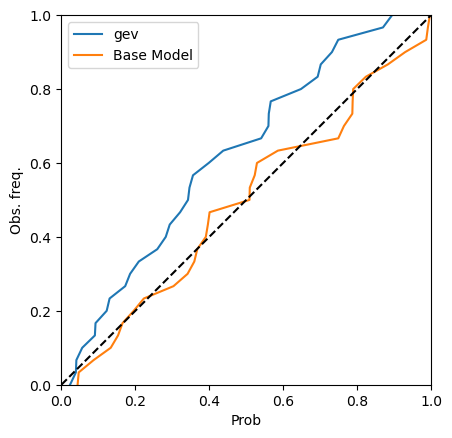

There are 31 values in the PIT diagram


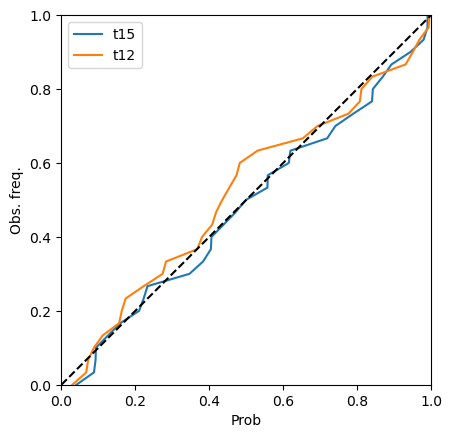

There are 31 values in the PIT diagram


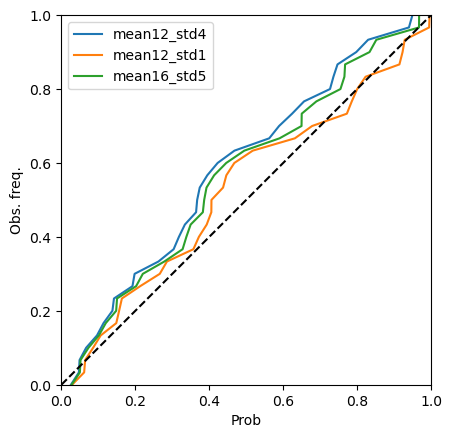

In [13]:
t = 17
make_cpit_diagram_emos(gev_models, X_test, y_test, variances_test, t=t, base_model=base_model)
make_cpit_diagram_emos(t_models, X_test, y_test, variances_test, t=t)
make_cpit_diagram_emos(cdf_models, X_test, y_test, variances_test, t=t)

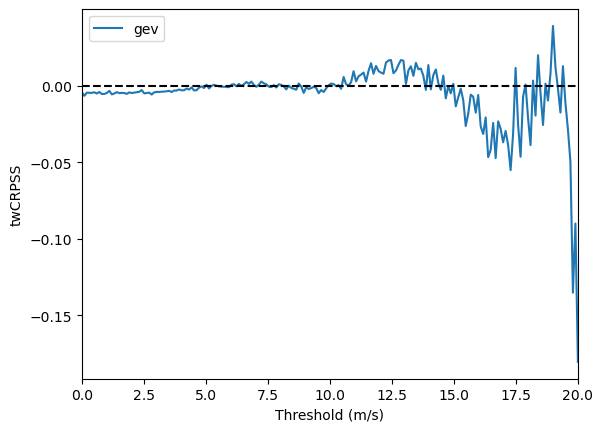

In [8]:
x_values = np.linspace(0, 20, 200)
make_twcrpss_plot(base_model, gev_models, X_test, y_test, variances_test, x_values, sample_size=1000)




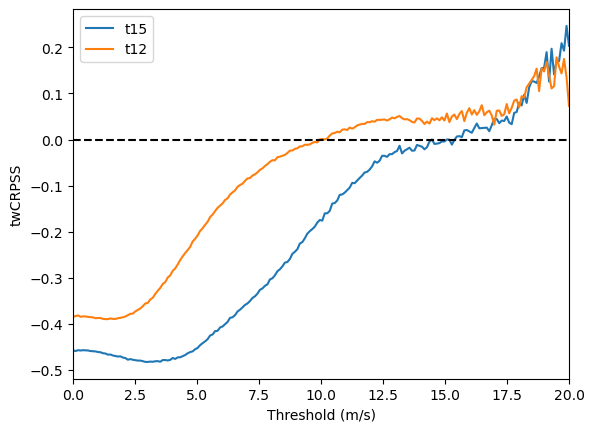

In [9]:
make_twcrpss_plot(base_model, t_models, X_test, y_test, variances_test, x_values, sample_size=1000)

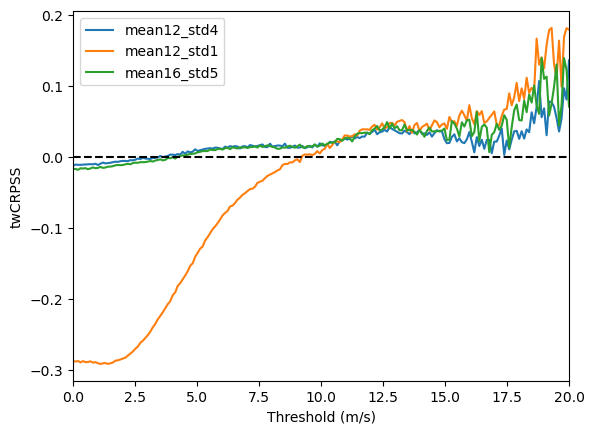

In [10]:
make_twcrpss_plot(base_model, cdf_models, X_test, y_test, variances_test, x_values, sample_size=1000)

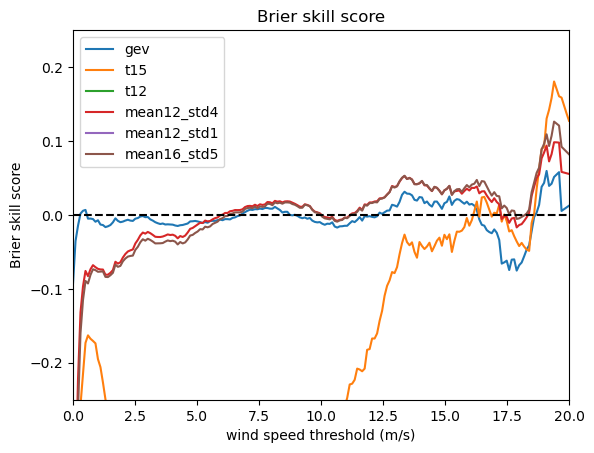

In [11]:
ylim = [-1,1]
#brier_skill_plot(base_model, all_models, X_test, y_test, variances_test, x_values, ylim=ylim)
ylim = [-0.25, 0.25]
brier_skill_plot(base_model, all_models, X_test, y_test, variances_test, x_values, ylim=ylim)

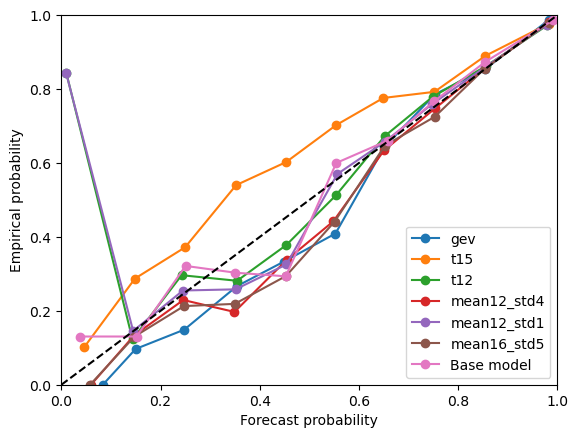

In [165]:
t = 12
make_reliability_diagram(all_models, X_test, y_test, variances_test, t=t, base_model=base_model)

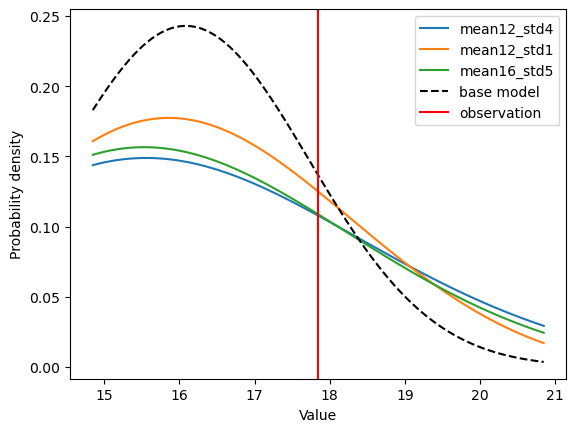

In [42]:
t = 17
plot_forecast_pdf(cdf_models, X_test, y_test, variances_test, observation_value=t, base_model=base_model)